In [36]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '..')

import warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
from pairing import Reader, Extractor, BaselineClassifier, GBClassifier, FilteredGBClassifier
import definition
import numpy as np
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Loading and Preprocessing

In [2]:
raw_data = Reader.read_file(definition.DATA_PAIRED_TRAIN)
raw_data[0]

{'token': ['kamar',
  'saya',
  'ada',
  'kendala',
  'di',
  'ac',
  'tidak',
  'berfungsi',
  'optimal',
  '.',
  'dan',
  'juga',
  'wifi',
  'koneksi',
  'kurang',
  'stabil',
  '.'],
 'label': ['O',
  'O',
  'O',
  'O',
  'O',
  'B-ASPECT',
  'B-SENTIMENT',
  'I-SENTIMENT',
  'I-SENTIMENT',
  'O',
  'O',
  'O',
  'B-ASPECT',
  'I-ASPECT',
  'B-SENTIMENT',
  'I-SENTIMENT',
  'O'],
 'aspect': [{'start': 5, 'length': 1}, {'start': 12, 'length': 2}],
 'sentiment': [{'start': 6, 'length': 3, 'index_aspect': [0]},
  {'start': 14, 'length': 2, 'index_aspect': [1]}]}

In [3]:
# extractor definition

embedding_filename = "word2vec_50.bin"
word_count_filename = "word_count_60.pkl"
clustering_filename = "word2vec_50_kmeans_50.pkl"

extractor = Extractor(
    embedding_filename=os.path.join(definition.MODEL_UTILITY, embedding_filename), 
    word_count_filename=os.path.join(definition.MODEL_UTILITY, word_count_filename),
    clustering_filename=os.path.join(definition.MODEL_UTILITY, clustering_filename))

In [4]:
data = extractor.extract_data(raw_data)

Extracting data: 100%|█████████████████████████████████████████████████████████████| 4000/4000 [00:50<00:00, 79.21it/s]


In [5]:
data_chen = extractor.extract_data(raw_data, include_new_features=False)

Extracting data: 100%|█████████████████████████████████████████████████████████████| 4000/4000 [00:48<00:00, 81.64it/s]


In [6]:
print('TOTAL', '[+]', '[-]', sep='\t')
print(len(data), len(data[data['target']==1]), len(data[data['target']==0]), sep='\t')

TOTAL	[+]	[-]
27894	8748	19146


In [7]:
X = data.drop('target', axis=1)
y = data['target']

X_chen = data_chen.drop('target', axis=1)
y_chen = data_chen['target']

In [8]:
X.describe(include="all")

,_id_aspect,_id_closest_sentiment,_id_sentence,_id_sentiment,_n_aspect,_n_sentiment,cos_aspect_sentence,cos_aspect_sentiment,cos_aspect_sentiment_validity,cos_sentiment_sentence,...,v_sentiment_45,v_sentiment_46,v_sentiment_47,v_sentiment_48,v_sentiment_49,v_sentiment_5,v_sentiment_6,v_sentiment_7,v_sentiment_8,v_sentiment_9
count,27894.000000,27894.000000,27894.000000,27894.000000,27894.000000,27894.000000,27894.000000,27894.000000,27894.000000,27894.000000,...,27894.000000,27894.000000,27894.000000,27894.000000,27894.000000,27894.000000,27894.000000,27894.000000,27894.000000,27894.000000
mean,1.581200,1.909550,1979.759984,1.953646,4.162401,4.907292,0.415881,0.184183,0.974331,0.429686,...,0.093748,1.590655,1.076279,-1.484029,-0.227094,0.478480,-0.337746,-0.025838,0.112124,0.237303
std,1.793977,1.995934,1148.287233,2.013907,2.360831,2.529206,0.209494,0.181290,0.158147,0.203547,...,1.221933,1.471443,1.269084,1.870378,1.474619,1.857541,1.110074,0.978354,1.938403,1.325352
min,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,-0.535566,-0.583915,0.000000,-0.566650,...,-5.105083,-3.917495,-4.036607,-5.882783,-5.143031,-3.758305,-3.668407,-3.021578,-4.713010,-4.698528
25%,0.000000,0.000000,960.000000,0.000000,2.000000,3.000000,0.287930,0.066104,1.000000,0.315573,...,-0.626339,0.537649,0.074207,-3.030760,-0.957772,-0.625553,-1.099299,-0.695181,-1.519508,-0.548453
50%,1.000000,1.000000,1994.000000,1.000000,4.000000,4.000000,0.445440,0.188263,1.000000,0.455528,...,0.310343,1.690161,1.065387,-1.549783,0.125720,0.747519,-0.076078,0.000000,0.087564,0.338100
75%,2.000000,3.000000,2963.000000,3.000000,5.000000,6.000000,0.572661,0.303586,1.000000,0.576059,...,0.626780,2.547805,2.066790,-0.059055,0.663761,1.665720,0.527881,0.481413,1.743133,1.122411
max,11.000000,13.000000,3999.000000,13.000000,12.000000,14.000000,0.976030,1.000000,1.000000,0.994282,...,5.882351,4.597618,5.920994,3.350471,5.089591,3.925813,4.375823,5.992032,4.145845,4.232138


## Exploration

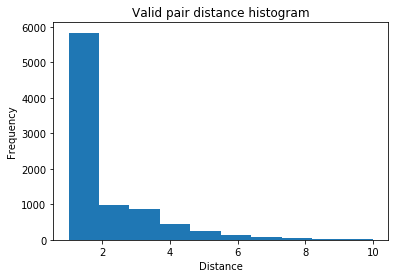

In [56]:
X_valid = X[y==1]
plt.hist(X_valid.dist_endpoint, range=(1,10))
plt.title("Valid pair distance histogram")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.show()

In [57]:
print("Mean distance of valid pair : ", end='')
print(np.mean(X_valid.dist_endpoint))
print("Quantile of distance of valid pair : ", end='')
print(np.quantile(X_valid.dist_endpoint, [0, 0.25, 0.5, 0.75, 1]))

Mean distance of valid pair : 1.875514403292181
Quantile of distance of valid pair : [ 1.  1.  1.  2. 27.]


## Validation

In [89]:
dummy_features = ['_id_sentence', '_id_aspect', '_id_sentiment', '_id_closest_sentiment', '_n_aspect', '_n_sentiment']

# Set dropped labels depending on classifier model
def drop_dummy_feature_baseline(X):
    return X.drop(labels=['_id_sentence', '_id_aspect', '_n_aspect'], axis=1)

# Set dropped labels depending on classifier model
def drop_dummy_feature(X):
    return X.drop(labels=['_id_sentence', '_id_aspect', '_id_sentiment', '_id_closest_sentiment', '_n_aspect'], axis=1)

In [90]:
parameters = {'num_leaves': [31, 63, 127],
              'max_depth': [6, 8, -1],
              'learning_rate': [0.1, 0.2],
              'n_estimators': [100, 200],
              'min_child_samples': [10, 20, 40]}

In [97]:
# K-Fold Cross Validation (Project)

n_splits = 5

available_sentence_id = pd.unique(X['_id_sentence'])
kfold = KFold(n_splits=n_splits, shuffle=True)
split_idx = 1
f1_0_total = 0.0
f1_1_total = 0.0
f1_a_total = 0.0
for train_sentence_id_index, test_sentence_id_index in kfold.split(available_sentence_id):
    print("[Split {}/{}]".format(split_idx, n_splits))
    split_idx += 1
    
    train_sentence_id = available_sentence_id[train_sentence_id_index]
    train_pointer = X['_id_sentence'].isin(train_sentence_id)
    X_train = X[train_pointer]
    X_test = X[np.bitwise_not(train_pointer)]
    y_train = y[train_pointer]
    y_test = y[np.bitwise_not(train_pointer)]
    
    model = FilteredGBClassifier(num_leaves=127, n_estimators=200)
    model.fit(drop_dummy_feature(X_train), y_train)
    pred = model.predict(drop_dummy_feature(X_test))
    f1_0 = f1_score(y_test, pred, pos_label=0)
    f1_1 = f1_score(y_test, pred, pos_label=1)
    f1_a = f1_score(y_test, pred, average='macro')
    f1_0_total += f1_0
    f1_1_total += f1_1
    f1_a_total += f1_a
    print("f1_0 : {}".format(f1_0))
    print("f1_1 : {}".format(f1_1))
    print("f1_a : {}".format(f1_a))
    print("")
    print(FilteredGBClassifier.generate_confusion_matrix_table(y_test, pred))
    print("")
    
print("[Summary]")
print("f1_0 : {}".format(f1_0_total/n_splits))
print("f1_1 : {}".format(f1_1_total/n_splits))
print("f1_a : {}".format(f1_a_total/n_splits))

[Split 1/5]
f1_0 : 0.961234071093226
f1_1 : 0.9113224915618289
f1_a : 0.9362782813275274

        predicted_0  predicted_1
true_0         3583           91
true_1          198         1485

[Split 2/5]
f1_0 : 0.963664707998561
f1_1 : 0.9128057553956834
f1_a : 0.9382352316971222

        predicted_0  predicted_1
true_0         4018           96
true_1          207         1586

[Split 3/5]
f1_0 : 0.9529755579171094
f1_1 : 0.8967327887981329
f1_a : 0.9248541733576212

        predicted_0  predicted_1
true_0         3587          133
true_1          221         1537

[Split 4/5]
f1_0 : 0.9586776859504132
f1_1 : 0.9085631349782294
f1_a : 0.9336204104643213

        predicted_0  predicted_1
true_0         3654          109
true_1          206         1565

[Split 5/5]
f1_0 : 0.9602649006622516
f1_1 : 0.9078014184397163
f1_a : 0.9340331595509839

        predicted_0  predicted_1
true_0         3770          105
true_1          207         1536

[Summary]
f1_0 : 0.9593633847243123
f1_1 : 0.90

In [92]:
# K-Fold Cross Validation (Chen)

n_splits = 5

available_sentence_id = pd.unique(X_chen['_id_sentence'])
kfold = KFold(n_splits=n_splits, shuffle=True)
split_idx = 1
f1_0_total = 0.0
f1_1_total = 0.0
f1_a_total = 0.0
for train_sentence_id_index, test_sentence_id_index in kfold.split(available_sentence_id):
    print("[Split {}/{}]".format(split_idx, n_splits))
    split_idx += 1
    
    train_sentence_id = available_sentence_id[train_sentence_id_index]
    train_pointer = X_chen['_id_sentence'].isin(train_sentence_id)
    X_train = X_chen[train_pointer]
    X_test = X_chen[np.bitwise_not(train_pointer)]
    y_train = y_chen[train_pointer]
    y_test = y_chen[np.bitwise_not(train_pointer)]
    
    model_chen = FilteredGBClassifier(num_leaves=127, n_estimators=200, max_depth=8)
    model_chen.fit(drop_dummy_feature(X_train), y_train)
    pred = model_chen.predict(drop_dummy_feature(X_test))
    f1_0 = f1_score(y_test, pred, pos_label=0)
    f1_1 = f1_score(y_test, pred, pos_label=1)
    f1_a = f1_score(y_test, pred, average='macro')
    f1_0_total += f1_0
    f1_1_total += f1_1
    f1_a_total += f1_a
    print("f1_0 : {}".format(f1_0))
    print("f1_1 : {}".format(f1_1))
    print("f1_a : {}".format(f1_a))
    print("")
    print(FilteredGBClassifier.generate_confusion_matrix_table(y_test, pred))
    print("")
    
print("[Summary]")
print("f1_0 : {}".format(f1_0_total/n_splits))
print("f1_1 : {}".format(f1_1_total/n_splits))
print("f1_a : {}".format(f1_a_total/n_splits))

[Split 1/5]
f1_0 : 0.9559505409582689
f1_1 : 0.9003496503496503
f1_a : 0.9281500956539597

        predicted_0  predicted_1
true_0         3711          105
true_1          237         1545

[Split 2/5]
f1_0 : 0.9548957675300063
f1_1 : 0.8944723618090452
f1_a : 0.9246840646695258

        predicted_0  predicted_1
true_0         3779          117
true_1          240         1513

[Split 3/5]
f1_0 : 0.9600312459315192
f1_1 : 0.9096793174463077
f1_a : 0.9348552816889135

        predicted_0  predicted_1
true_0         3687           89
true_1          218         1546

[Split 4/5]
f1_0 : 0.9611326298918124
f1_1 : 0.9131083905643476
f1_a : 0.93712051022808

        predicted_0  predicted_1
true_0         3598           95
true_1          196         1529

[Split 5/5]
f1_0 : 0.961524000501316
f1_1 : 0.9096793174463078
f1_a : 0.9356016589738119

        predicted_0  predicted_1
true_0         3836          129
true_1          178         1546

[Summary]
f1_0 : 0.9587068369625846
f1_1 : 0.905

## Training

In [93]:
model.model

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=200, n_jobs=-1, num_leaves=127, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [94]:
model_chen.model

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=8,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=200, n_jobs=-1, num_leaves=127, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [95]:
model.fit(drop_dummy_feature(X), y)
model_pairing_filename = "pairing_final.pkl"
model.save(os.path.join(definition.MODEL_PAIRING, model_pairing_filename))

In [96]:
model_chen.fit(drop_dummy_feature(X_chen), y_chen)
model_pairing_filename = "pairing_final_chen.pkl"
model_chen.save(os.path.join(definition.MODEL_PAIRING, model_pairing_filename))

## Testing

In [98]:
raw_test = Reader.read_file(definition.DATA_PAIRED_TEST)
raw_test[0]

{'token': ['pelayanan',
  'ramah',
  ',',
  'kamar',
  'nyaman',
  'dan',
  'fasilitas',
  'lengkap',
  '.',
  'hanya',
  'airnya',
  'showernya',
  'kurang',
  'panas',
  '.'],
 'label': ['B-ASPECT',
  'B-SENTIMENT',
  'O',
  'B-ASPECT',
  'B-SENTIMENT',
  'O',
  'B-ASPECT',
  'B-SENTIMENT',
  'O',
  'O',
  'B-ASPECT',
  'I-ASPECT',
  'B-SENTIMENT',
  'I-SENTIMENT',
  'O'],
 'aspect': [{'start': 0, 'length': 1},
  {'start': 3, 'length': 1},
  {'start': 6, 'length': 1},
  {'start': 10, 'length': 2}],
 'sentiment': [{'start': 1, 'length': 1, 'index_aspect': [0]},
  {'start': 4, 'length': 1, 'index_aspect': [1]},
  {'start': 7, 'length': 1, 'index_aspect': [2]},
  {'start': 12, 'length': 2, 'index_aspect': [3]}]}

In [99]:
test = extractor.extract_data(raw_test)

Extracting data: 100%|█████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 78.96it/s]


In [100]:
test_chen = extractor.extract_data(raw_test, include_new_features=False)

Extracting data: 100%|█████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 79.95it/s]


In [101]:
print('TOTAL', '[+]', '[-]', sep='\t')
print(len(test), len(test[test['target']==1]), len(test[test['target']==0]), sep='\t')

TOTAL	[+]	[-]
7085	2148	4937


In [102]:
X_test = test.drop('target', axis=1)
y_test = test['target']

X_test_chen = test_chen.drop('target', axis=1)
y_test_chen = test_chen['target']

In [103]:
# baseline

model_baseline = BaselineClassifier()
pred_test_baseline = model_baseline.predict(drop_dummy_feature_baseline(X_test))
f1_0 = f1_score(y_test, pred_test_baseline, pos_label=0)
f1_1 = f1_score(y_test, pred_test_baseline, pos_label=1)
f1_a = f1_score(y_test, pred_test_baseline, average='macro')
print("f1_0 : {}".format(f1_0))
print("f1_1 : {}".format(f1_1))
print("f1_a : {}".format(f1_a))
print("")
print(BaselineClassifier.generate_confusion_matrix_table(y_test, pred_test_baseline))
print("")

f1_0 : 0.9561697926949654
f1_1 : 0.8900990099009901
f1_a : 0.9231344012979777

        predicted_0  predicted_1
true_0         4843           94
true_1          350         1798



In [104]:
# best model

model_best = FilteredGBClassifier()
model_best.load(os.path.join(definition.MODEL_PAIRING, "pairing_final.pkl"))
pred_test_best = model_best.predict(drop_dummy_feature(X_test))
f1_0 = f1_score(y_test, pred_test_best, pos_label=0)
f1_1 = f1_score(y_test, pred_test_best, pos_label=1)
f1_a = f1_score(y_test, pred_test_best, average='macro')
print("f1_0 : {}".format(f1_0))
print("f1_1 : {}".format(f1_1))
print("f1_a : {}".format(f1_a))
print("")
print(FilteredGBClassifier.generate_confusion_matrix_table(y_test, pred_test_best))
print("")

f1_0 : 0.9605540499849444
f1_1 : 0.9065842643213691
f1_a : 0.9335691571531568

        predicted_0  predicted_1
true_0         4785          152
true_1          241         1907



In [106]:
# chen model

model_chen = FilteredGBClassifier()
model_chen.load(os.path.join(definition.MODEL_PAIRING, "pairing_final_chen.pkl"))
pred_test_chen = model_chen.predict(drop_dummy_feature(X_test_chen))
f1_0 = f1_score(y_test_chen, pred_test_chen, pos_label=0)
f1_1 = f1_score(y_test_chen, pred_test_chen, pos_label=1)
f1_a = f1_score(y_test_chen, pred_test_chen, average='macro')
print("f1_0 : {}".format(f1_0))
print("f1_1 : {}".format(f1_1))
print("f1_a : {}".format(f1_a))
print("")
print(FilteredGBClassifier.generate_confusion_matrix_table(y_test_chen, pred_test_chen))
print("")

f1_0 : 0.9612527604898614
f1_1 : 0.9082699619771863
f1_a : 0.9347613612335239

        predicted_0  predicted_1
true_0         4788          149
true_1          237         1911

